In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from time import time
from functools import partial

jax.config.update("jax_enable_x64", True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport solver.hydro
%aimport solver.solvers
%aimport solver.limiters
%aimport solver.muscl

# Blast Wave in 2-D

In [3]:
def imshow(f, size=10, axis=None):
    plt.figure(figsize=(size, size))
    if axis is None:
        extent = None
    else:
        extent = [axis.min(), axis.max(), axis.min(), axis.max()]

    plt.imshow(np.transpose(f), origin="lower", extent=extent)
    plt.colorbar()


def title(e0=1e5, d0=1.0, C=0.5, n=128):
    plt.title("e0={:.0e}   d0={:.0e}   C={:.1f}  n={}".format(e0, d0, C, n))

In [4]:
def blast_func(x, y, n, ds, e0=1e3, d0=0.0, power=2, w=3.0):
    # distance to center
    radius = jnp.sqrt(x[:, None] ** 2 + y[None, :] ** 2)
    profile = jnp.exp(-((radius / (w * ds)) ** power))
    B = 1 / (ds**2 * jnp.sum(profile))
    return np.ones((n, n)) + B * e0 * profile


state = solver.hydro.create_hydro_state(128, 2.0, func=partial(blast_func, w=10))

Skipped CUDA versions constraints check due to the JAX_SKIP_CUDA_CONSTRAINTS_CHECK env var being set.


2024-05-24 02:19:42.824120: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


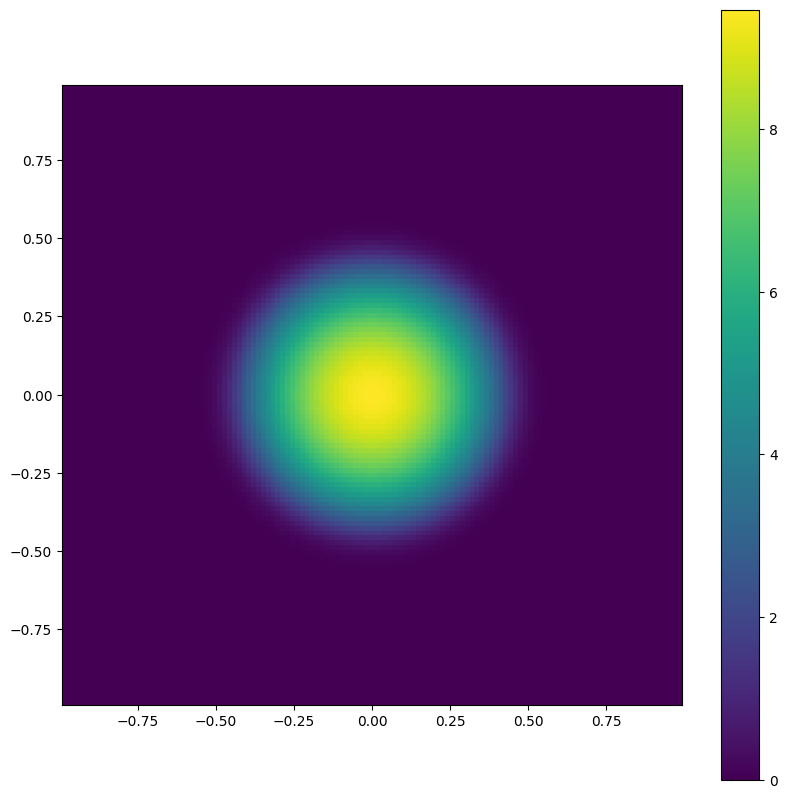

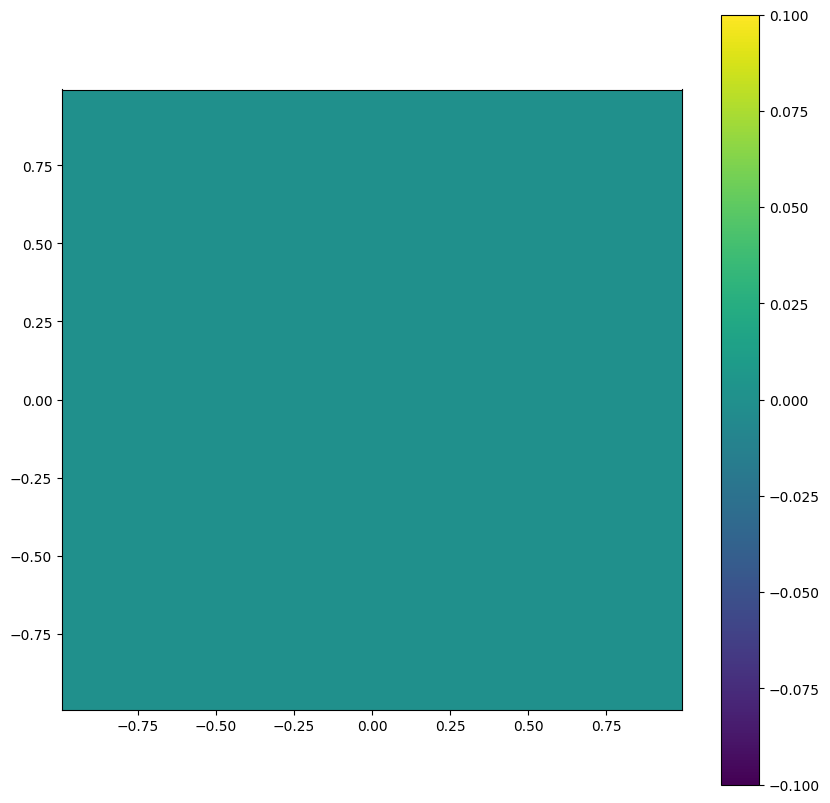

In [5]:
imshow(np.log(state.total_energy), axis=state.x)
imshow(np.log(state.density), axis=state.x)

### A small Blast Wave example

2.4 sec, 0.09 microseconds/update


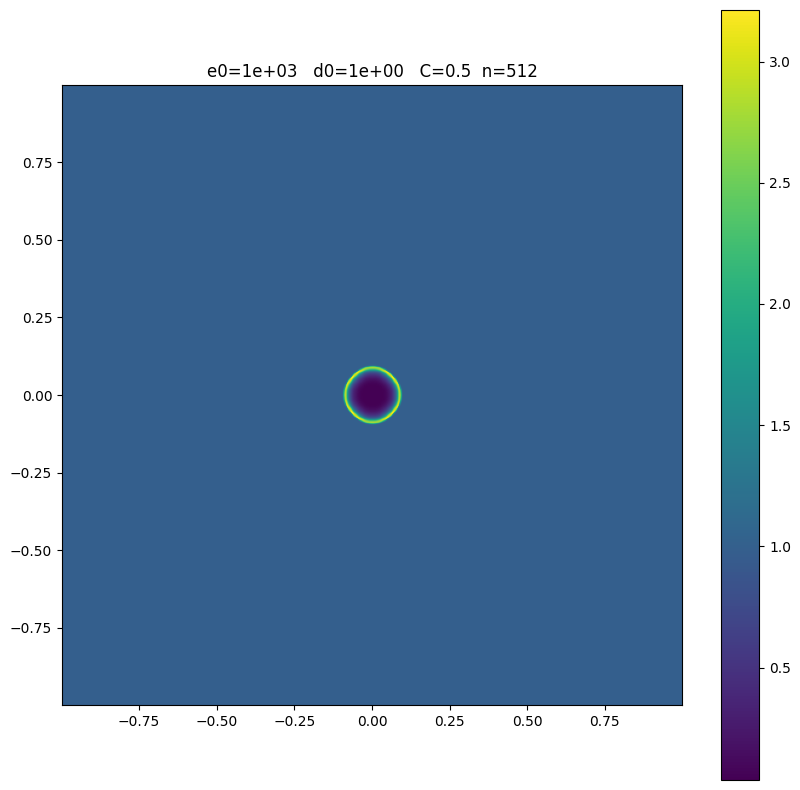

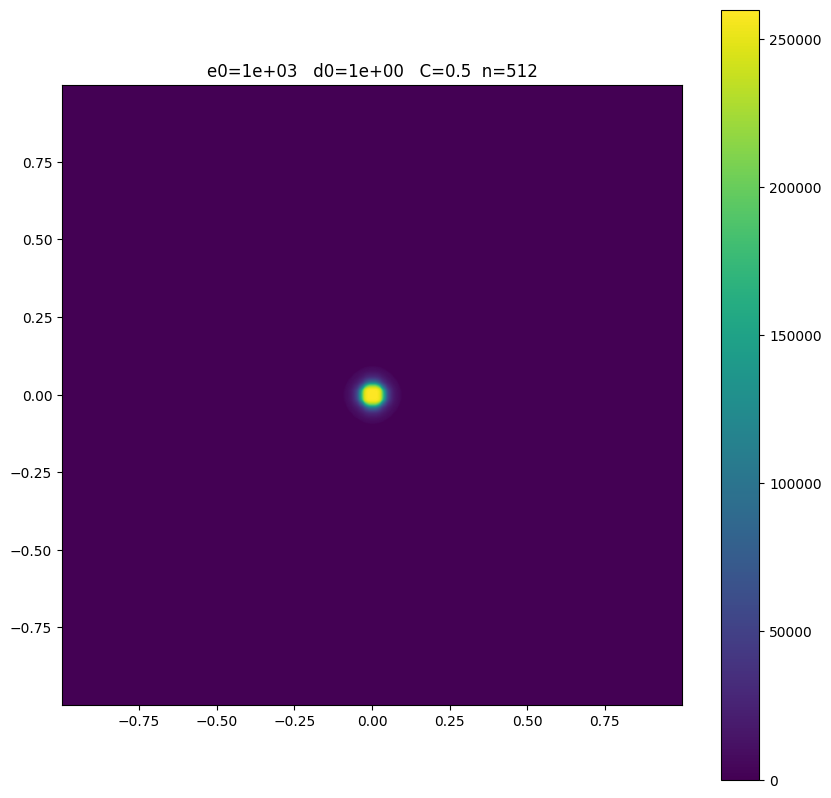

In [6]:
e0 = 1e3
n = 512
C = 0.5
nt = 100
riemann_solver = solver.solvers.local_lax_friedrichs
slope_limiter = solver.limiters.monotonized_central
state = solver.hydro.create_hydro_state(n, 2.0, func=partial(blast_func, e0=e0, power=4, w=3.0))
start = time()

for it in range(nt):
    startl = time()
    dt = solver.hydro.courant_condition(state, C)
    state = solver.muscl.muscl_2d(
        state, dt, slope_limiter=slope_limiter, riemann_solver=riemann_solver
    )
    usedl = time() - startl
    #print("{:.1f} sec, {:.2f} microseconds/update".format(usedl, 1e6 * usedl / (n**2)))
used = time() - start

print("{:.1f} sec, {:.2f} microseconds/update".format(used, 1e6 * used / (n**2 * nt)))
imshow(state.density, axis=state.x)
title(e0=e0, C=C, n=n)
imshow(solver.hydro.temperature(state), axis=state.x)
title(e0=e0, C=C, n=n)

In [7]:
checksum = np.sum(state.density)
print('checksum =',checksum)
print('energy =',np.sum(state.total_energy))

checksum = 262144.0
energy = 65798143.999999985


## Weak scaling behaviour

In [8]:
import pandas as pd

In [9]:
def measure_weak_scaling(min, max) -> pd.DataFrame:
    results = []

    for i in range(min, max):
        n = 2**i
        state = solver.hydro.create_hydro_state(n, 2.0, func=partial(blast_func, e0=1e3, power=4, w=3.0))
        start = 0

        for it in range(100):
            if it == 0:
                start = time()

            dt = solver.hydro.courant_condition(state, 0.5)
            state = solver.muscl.muscl_2d(
                state, dt, slope_limiter=slope_limiter, riemann_solver=riemann_solver
            )

        used = time() - start
        checksum = np.sum(state.density)
        update_ms = 1e6 * used / (n**2 * 100)
        results.append({'n': n, 'total_s': used, 'update_ms': update_ms, 'checksum': checksum})
    return pd.DataFrame(results)

df = measure_weak_scaling(1, 12)


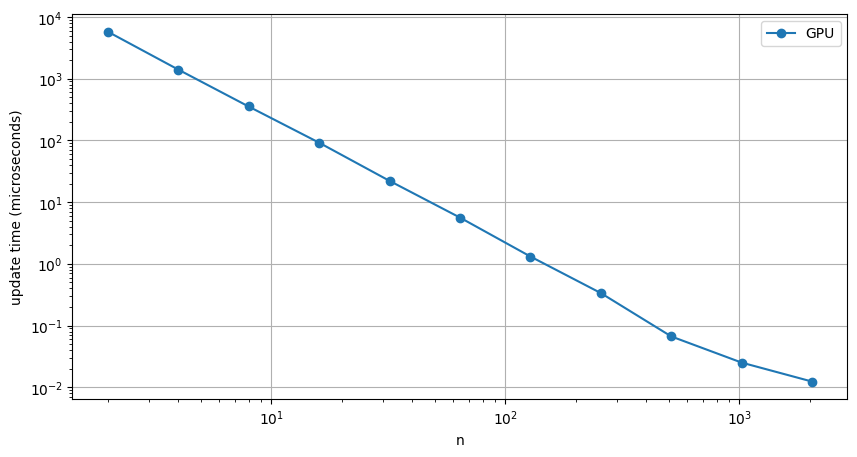

In [16]:
def plot_weak_scaling(df: pd.DataFrame):
    plt.figure(figsize=(10, 5))
    plt.plot(df['n'], df['update_ms'], 'o-', label="GPU")
    plt.xlabel('n')
    plt.ylabel('update time (microseconds)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

plot_weak_scaling(df)